In [55]:
%config IPCompleter.greedy=True
import json
from collections import defaultdict
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tqdm.notebook import tqdm as tqdm

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt 
from collections import defaultdict
from itertools import product
from random import choices
import io
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sns.set(style="whitegrid", font="serif", font_scale=1)

In [3]:
def json_read(filename):
    with open(filename, 'r') as inf:
        res = json.load(inf)
    return res

def json_dump(obj, filename, ea=False, indent=4):
    with open(filename, 'w') as ouf:
        json.dump(obj, ouf, ensure_ascii=ea, indent=indent)

### Drawing

In [28]:
def plot_pca(pairs, word_to_array):
    signs = []
    for w1, w2, s in pairs:
        if s == '+':
            signs.append('+')
        else:
            signs.append('-')
#             if (w1, w2) in test_hard_ants_pairs:
#                 signs.append('!')
#             else:
#                 signs.append('-')
    signs = np.array(signs)
    vectors_data = [
        (np.array(word_to_array[fst]), np.array(word_to_array[scnd])) for fst, scnd, _ in pairs
    ]
    sq_dif = np.array([np.square(fst - scnd) for fst, scnd in vectors_data])
    pca = PCA(n_components=2)
    pca.fit(sq_dif.T)
    new_sq_data = pca.components_
    formated_data = pd.DataFrame(
        {
            'PCA1': new_sq_data[0], 
            'PCA2': new_sq_data[1],
            'type': signs
        }
    )
    plt.figure(figsize=(12, 8))
    ax = sns.scatterplot(
        x="PCA1", 
        y="PCA2", 
        hue='type', 
        s=100,
        data=formated_data)
    ax.set(xlim=(-0.03, 0.05))
    ax.set(ylim=(-0.05, 0.05))
    plt.xlabel(r'$PCA_1$', size=18)
    plt.ylabel(r'$PCA_2$', size=18)
    ax.tick_params(labelsize=16)
    plt.show()

In [183]:
tsne_points = []
def plot_tsne(pairs, word_to_array, other_pairs=None):
    signs = []
    for w1, w2, s in pairs:
        if s == '+':
            signs.append('+')
        else:
            signs.append('-')
#             if (w1, w2) in test_hard_ants_pairs:
#                 signs.append('!')
#             else:
#                 signs.append('-')
    if other_pairs is not None:
        pairs = pairs + other_pairs
        for _, _, s in other_pairs:
            signs.append(s + ' test')
    signs = np.array(signs)
    
    vectors_data = [
        (np.array(word_to_array[fst]), np.array(word_to_array[scnd])) for fst, scnd, _ in pairs
    ]
    sq_dif = np.array([np.square(fst - scnd) for fst, scnd in vectors_data])
    X_embedded = TSNE(n_components=2).fit_transform(sq_dif)
    tsne_points = X_embedded
    formated_data_tsne = pd.DataFrame(
        {
            'x1': X_embedded.T[0], 
            'x2': X_embedded.T[1],
            'type': signs
        }
    )
    plt.figure(figsize=(12, 12))
    ax = sns.scatterplot(
        x="x1", 
        y="x2", 
        hue='type', 
        s=100,
        data=formated_data_tsne)
    plt.xlabel(r'$x_1$', size=18)
    plt.ylabel(r'$x_2$', size=18)
    ax.tick_params(labelsize=16)
    plt.show()

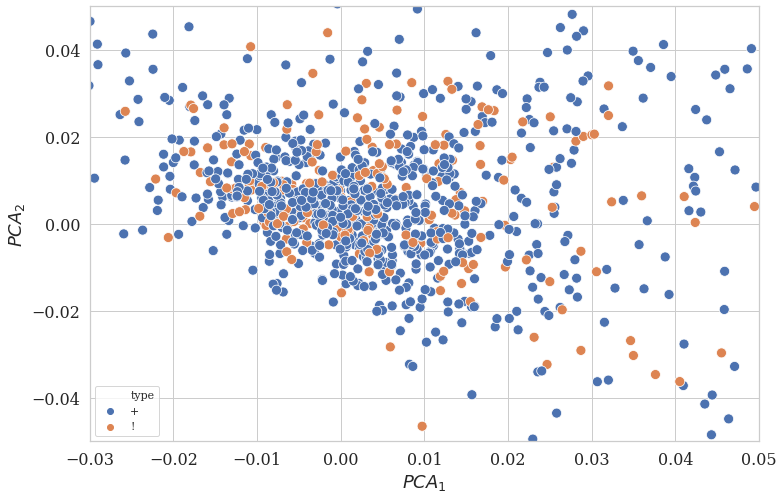

In [420]:
plot_pca(test_word_pairs, embeddings)

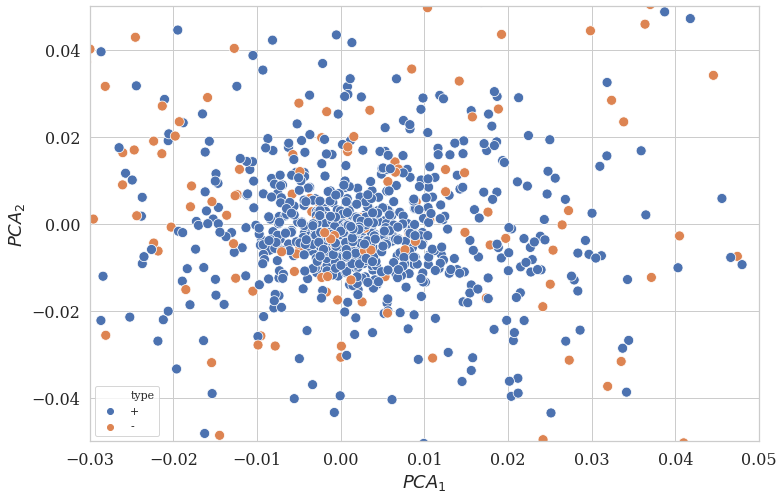

In [30]:
plot_pca(test_word_pairs, tuned_embeddings)

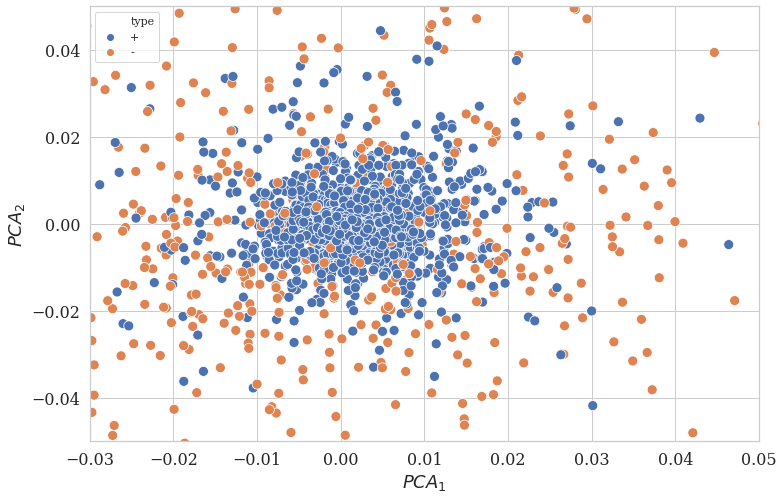

In [31]:
plot_pca(train_word_pairs, tuned_embeddings)

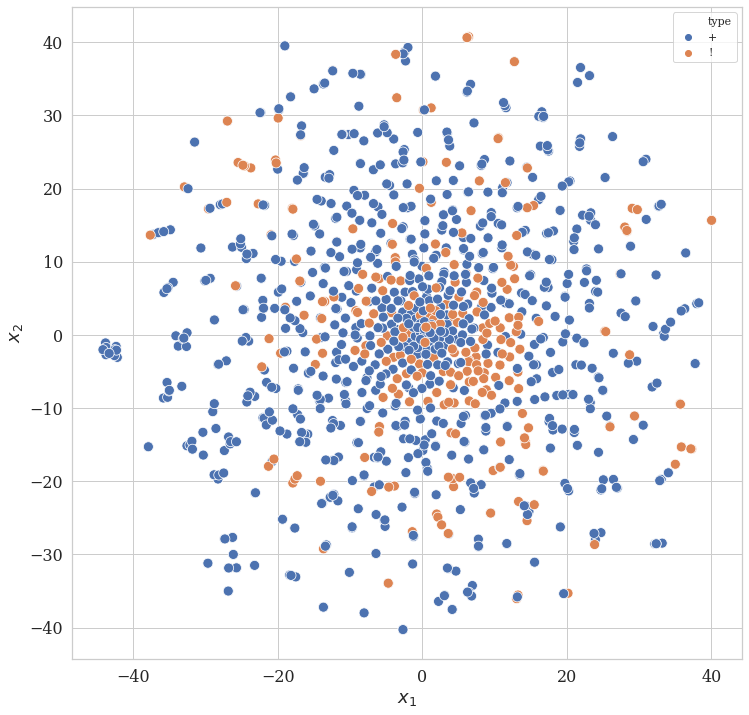

In [424]:
plot_tsne(test_word_pairs, embeddings)

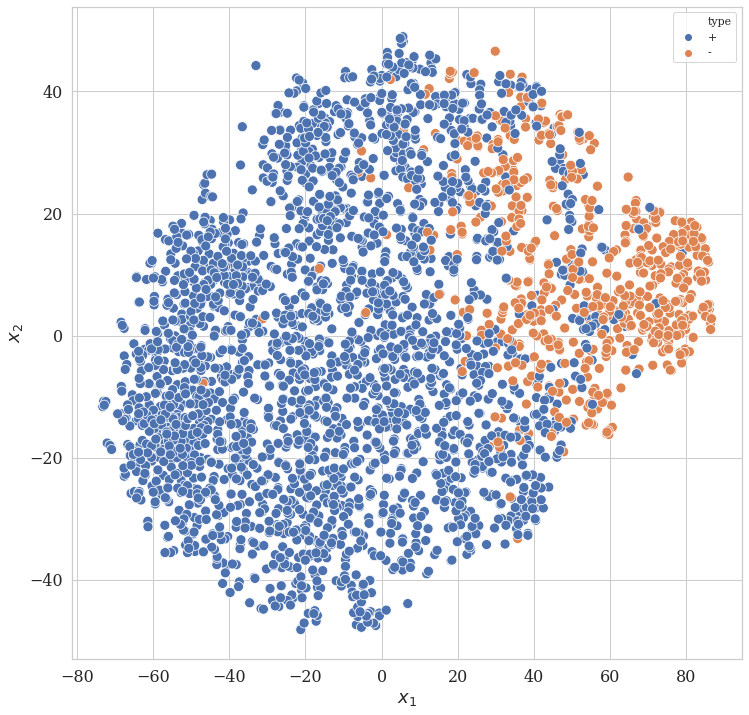

In [194]:
plot_tsne(train_word_pairs, tuned_embeddings)

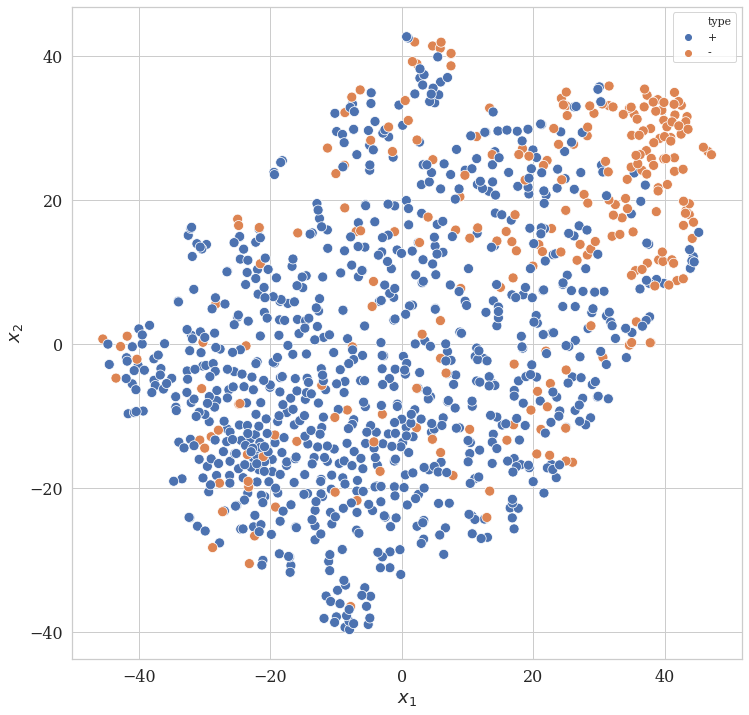

In [32]:
plot_tsne(test_word_pairs, tuned_embeddings)

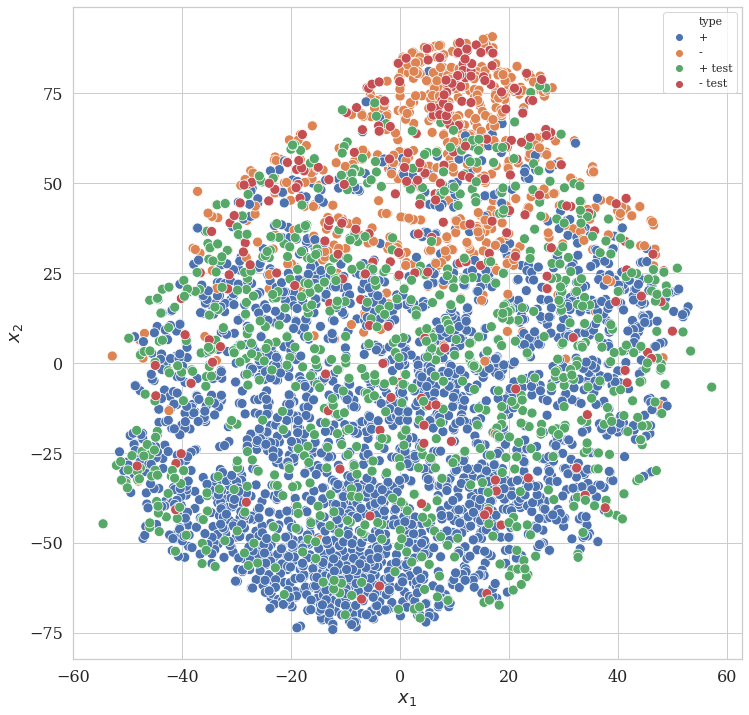

In [35]:
plot_tsne(train_word_pairs, tuned_embeddings, test_word_pairs)

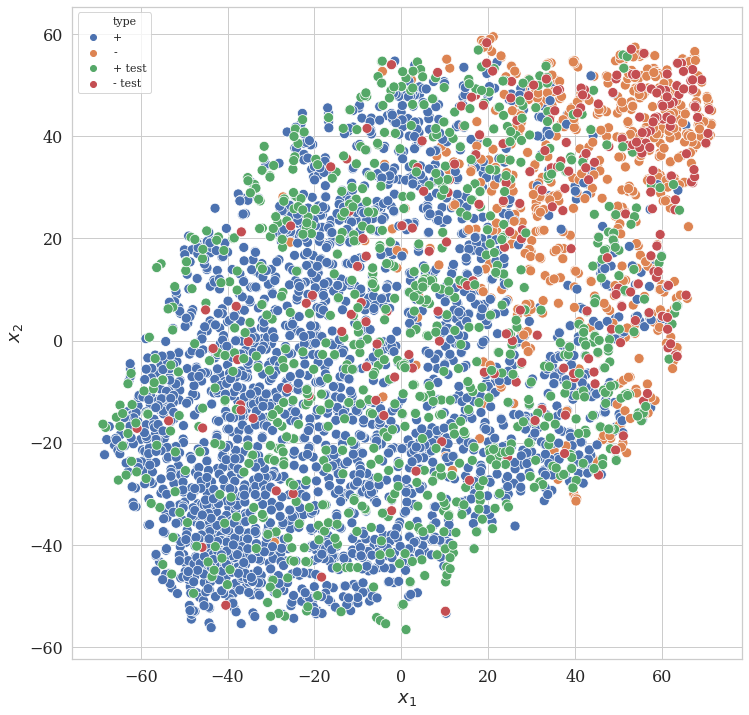

In [184]:
plot_tsne(train_word_pairs, mixed_embeddings, test_word_pairs)

In [185]:
len(tsne_points)

0

### Load data

### Fasttext

In [40]:
embeddings = {}

In [41]:
cnt = 0
with open('crawl-300d-2M.vec', 'r', encoding='utf-8', newline='\n', errors='ignore') as inf:
    next(inf)
    for line in tqdm(inf):
        tokens = line.rstrip().split()
        word = tokens[0]
        if word in vocabulary:
            embeddings[word] = list(map(float, tokens[1:]))

# def load_vectors(fname):
#     fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
#     n, d = map(int, fin.readline().split())
#     data = {}
#     for line in fin:
#         tokens = line.rstrip().split(' ')
#         data[tokens[0]] = map(float, tokens[1:])
#     return data

In [6]:
embeddings = json_read('crawl_emb.json')

In [7]:
train_word_pairs = json_read('train_dataset.json')
test_word_pairs = json_read('test_dataset.json')

In [38]:
existing_word_pairs = []
for w1, w2, label in word_pairs:
    if w1 in embeddings and w2 in embeddings:
        existing_word_pairs.append([w1, w2, label])

In [8]:
def get_svm_data(word_pairs, embeddings):
    inputs = []
    labels = []
    for w1, w2, label in word_pairs:
        if w1 in embeddings and w2 in embeddings:
            e1 = np.array(embeddings[w1])
            e2 = np.array(embeddings[w2])
            inputs.append(np.square(e1 - e2))
            labels.append(label)
    inputs = np.vstack(inputs)
    labels = np.array(labels)
    return inputs, labels

In [9]:
class NetDataloader:
    def __init__(self, word_pairs, embeddings):
        self.inputs = []
        for w1, w2, label in word_pairs:
            if w1 in embeddings and w2 in embeddings:
                e1 = np.array([embeddings[w1]])
                e2 = np.array([embeddings[w2]])
                lb = 1 if label == '+' else -1
                self.inputs.append((e1, e2, lb))
                
    def __iter__(self):
        for input1, input2, label in self.inputs:
            input1 = from_numpy(input1).float()
            input2 = from_numpy(input2).float()
            label = Tensor([label])
            yield input1, input2, label
            
    def __len__(self):
        return len(self.inputs)

In [10]:
class WeightedNetDataloader:
    def __init__(self, word_pairs, embeddings):
        self.size = 0
        self.class_data = {}
        for w1, w2, label in word_pairs:
            if w1 in embeddings and w2 in embeddings:
                e1 = np.array([embeddings[w1]])
                e2 = np.array([embeddings[w2]])
                lb = 1 if label == '+' else -1
                if lb not in self.class_data:
                    self.class_data[lb] = []
                self.class_data[lb].append((e1, e2, lb))
                self.size += 1
        self.labels_dict = [label for i, label in enumerate(self.class_data)]
        self.weights = [self.size / len(self.class_data[self.labels_dict[i]]) for i in range(len(self.labels_dict))]
        weights_sum = sum(self.weights)
        self.weights = [x / weights_sum for x in self.weights]
                
    def __iter__(self):
        for i in range(self.size):
            label = np.random.choice(self.labels_dict, p=self.weights)
            e1, e2, lb = self.class_data[label][np.random.choice(len(self.class_data[label]))]
            input1 = from_numpy(e1).float()
            input2 = from_numpy(e2).float()
            label = Tensor([lb])
            yield input1, input2, label
            
    def __len__(self):
        return self.size

In [73]:
inputs, labels = get_svm_data(test_word_pairs, embeddings)

In [12]:
print(np.sum(labels == '+'))
print(np.sum(labels == '-'))

2525
615


### SVM

In [175]:
raw_inputs, raw_labels = get_svm_data(test_word_pairs, embeddings)
inputs, labels = get_svm_data_from_processed(net, NetDataloader(test_word_pairs, embeddings))

In [177]:
inputs = np.hstack([raw_inputs, inputs])

In [178]:
inputs.shape

(1097, 350)

In [135]:
mixed_inputs, _ = get_svm_data(test_word_pairs, mixed_embeddings)

In [192]:
tuned_inputs, _ = get_svm_data(test_word_pairs, tuned_embeddings)

In [190]:
tuned_inputs.shape

(3140, 50)

In [121]:
def run_svm(inputs, labels):
    classifier = SVC(C=10, kernel='linear', class_weight={'+': 0.25, '-': 0.75}, max_iter=300000)
    inputs = MinMaxScaler().fit_transform(inputs)
    classifier.fit(inputs, labels)
    pred = classifier.predict(inputs)
    results = defaultdict(int)
    for i in range(len(pred)):
        res = labels[i] + pred[i]
        results[res] += 1
    print(f'synonims: {results["++"] / (results["+-"] + results["++"])}')
    print(f'antonims: {results["--"] / (results["--"] + results["-+"])}')

In [195]:
run_svm(mixed_inputs, labels)

synonims: 0.9409681227863046
antonims: 0.98


In [274]:
inputs, labels = get_svm_data(train_word_pairs, embeddings)
hard_word_pairs = []
classifier = SVC(kernel='linear', class_weight={'+': 0.25, '-': 0.75})
classifier.fit(inputs, labels)
for i in range(len(train_word_pairs)):
    pred = classifier.predict([inputs[i]])[0]
    if labels[i] == '-' or pred != labels[i] :
        hard_word_pairs.append(train_word_pairs[i])

In [275]:
len(hard_word_pairs)

951

In [157]:
e1 = np.array(embeddings['absolve'])
e2 = np.array(embeddings['free'])
# e2 = np.array(embeddings['blame'])
np.linalg.norm(e1 - e2)

5.487058521648917

### PyTorch

In [14]:
import torch
import torch.nn as nn
from torch import Tensor, optim, from_numpy 

In [180]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(300, 100),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(100, 50)
        )
    
    def forward_once(self, x):
        output = self.fc(x)
        return output
    
    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
    
    def save(filename):
        torch.save(self.state_dict(), filename)
        
    def load(filename):
        self.load_state_dict(torch.load(filename))

In [181]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super().__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        label = label.numpy()[0]
        if label < 0:
            label = 0.0
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((label) * torch.pow(euclidean_distance, 2) +
                                      (1-label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [182]:
net = SiameseNetwork()
criterion = nn.CosineEmbeddingLoss(margin=-2.0, reduction='none')
criterion = ContrastiveLoss(margin=50.0)
optimizer = optim.RMSprop(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-5)
dataloader = WeightedNetDataloader(train_word_pairs, embeddings)

In [172]:
def train(n_epochs=20):
    net.train()
    
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for data in tqdm(dataloader):
            input1, input2, label = data
            optimizer.zero_grad()
            output1, output2 = net(input1, input2)
            loss = criterion(output1, output2, label)
            ###
#             print(label.numpy()[0])
#             out1 = output1.detach().numpy()
#             out2 = output2.detach().numpy()
#             print(np.linalg.norm(out1[0] - out2[0]))
#             print(loss.item())
            ###
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        epoch_loss /= len(dataloader)
        print(f'Epoch {epoch}\n Current loss {epoch_loss:.4f}')
        epoch_loss = 0.0

In [173]:
train(40)


Epoch 0
 Current loss 388.0824



Epoch 1
 Current loss 160.3064



Epoch 2
 Current loss 116.3172



Epoch 3
 Current loss 83.2966



Epoch 4
 Current loss 66.9231



Epoch 5
 Current loss 56.9292



Epoch 6
 Current loss 39.2544



Epoch 7
 Current loss 32.8728



Epoch 8
 Current loss 29.2604



Epoch 9
 Current loss 26.8446



Epoch 10
 Current loss 27.5644



Epoch 11
 Current loss 25.0586



Epoch 12
 Current loss 18.4885



Epoch 13
 Current loss 17.4780



Epoch 14
 Current loss 17.5025



Epoch 15
 Current loss 15.5852



Epoch 16
 Current loss 17.8540



Epoch 17
 Current loss 12.7811



Epoch 18
 Current loss 11.7524



Epoch 19
 Current loss 10.7675



Epoch 20
 Current loss 12.2153



Epoch 21
 Current loss 13.0856



Epoch 22
 Current loss 10.7594



Epoch 23
 Current loss 9.9280



Epoch 24
 Current loss 8.5652



Epoch 25
 Current loss 10.5948



Epoch 26
 Current loss 10.6240



Epoch 27
 Current loss 6.3285



Epoch 28
 Current loss 10.5315



Epoch 29
 Current loss 8.0710



Epoch 30
 Current loss 7.7288



Epoch 31
 Current loss 7.6563



Epoch 32
 Current loss 7.0540



Epoch 33
 Current loss 7.3794



Epoch 34
 Current loss 5.5537



Epoch 35
 Current loss 5.0598



Epoch 36
 Current loss 7.4127



Epoch 37
 Current loss 7.1931



Epoch 38
 Current loss 6.8565



Epoch 39
 Current loss 6.8321


In [174]:
net.eval()

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=50, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
  )
)

In [411]:
results = defaultdict(int)
test_hard_ants_pairs = []
for i, data in enumerate(NetDataloader(test_word_pairs, embeddings)):
    input1, input2, label = data
    out1, out2 = net(input1, input2)
    out1 = out1.detach().numpy()
    out2 = out2.detach().numpy()
    label = '+' if label.numpy()[0] == 1. else '-'
#     dist = cosine_similarity(out1, out2)[0][0]
    dist = np.linalg.norm(out1[0] - out2[0])
    print(test_word_pairs[i], dist)
    if dist > 0:
        if label == '-':
            test_hard_ants_pairs.append((test_word_pairs[i][0], test_word_pairs[i][1]))
#             print(test_word_pairs[i], dist)
        label += '+'
    else:
#         if label == '-':
#             print(test_word_pairs[i], dist)
        label += '-'
    results[label] += 1
    
# print(f'synonims: {results["++"] / (results["+-"] + results["++"])}')
# print(f'antonims: {results["--"] / (results["--"] + results["-+"])}')

['centralise', 'centralize', '+'] 5.78205
['crucial', 'important', '+'] 4.143045
['blood', 'origin', '+'] 12.5907755
['naturally', 'unnaturally', '-'] 17.65504
['bloodline', 'line', '+'] 12.88782
['open', 'shut', '-'] 13.060927
['black', 'inkiness', '+'] 14.920757
['bear', 'behave', '+'] 10.337896
['ancestor', 'root', '+'] 15.656989
['cerebral', 'emotional', '-'] 8.715479
['dateable', 'undatable', '-'] 18.456432
['exchange', 'interchange', '+'] 7.4644847
['reanimate', 'vivify', '+'] 13.782633
['diffident', 'timid', '+'] 6.5016646
['origin', 'parentage', '+'] 11.186044
['flaky', 'outre', '+'] 16.622358
['blackness', 'white', '-'] 12.991197
['enliven', 'invigorate', '+'] 5.6747923
['frigidity', 'frigidness', '+'] 7.6331162
['bizarre', 'outre', '+'] 7.991581
['demobilise', 'mobilise', '-'] 18.310766
['compliance', 'compliancy', '+'] 7.1256523
['cook', 'falsify', '+'] 18.57357
['accessible', 'inaccessible', '-'] 31.642378
['assail', 'round', '+'] 15.4345045
['compassionate', 'pity', '+'] 1

['attack', 'flak', '+'] 6.875105
['confused', 'disordered', '+'] 9.283793
['coldness', 'frigidness', '+'] 4.660961
['energise', 'excite', '+'] 8.434118
['alter', 'modify', '+'] 6.0652556
['black', 'opprobrious', '+'] 10.966354
['change', 'exchange', '+'] 15.054056
['centralizing', 'decentralizing', '-'] 8.120224
['conduct', 'deport', '+'] 5.8348546
['fame', 'infamy', '-'] 20.523355
['compassionate', 'uncompassionate', '-'] 39.679443
['misrepresent', 'wangle', '+'] 23.172365
['extraction', 'origin', '+'] 10.847104
['onrush', 'onslaught', '+'] 11.434323
['change', 'deepen', '+'] 10.451892
['cold', 'inhuman', '+'] 12.328761
['deterrence', 'disincentive', '+'] 19.24125
['black-market', 'smuggled', '+'] 17.308239
['onrush', 'onset', '+'] 14.758479
['repair', 'vivify', '+'] 16.380093
['case', 'type', '+'] 7.3731318
['downslope', 'fall', '+'] 9.026589
['distort', 'falsify', '+'] 8.754451
['broken', 'impoverished', '+'] 14.308466
['disorder', 'trouble', '+'] 11.035635
['dissimilar', 'similar',

['arouse', 'brace', '+'] 13.156304
['compliance', 'deference', '+'] 17.067587
['arched', 'arching', '+'] 4.6844363
['ancestor', 'ascendent', '+'] 11.213245
['celebrity', 'renown', '+'] 11.528621
['acquit', 'comport', '+'] 12.206525
['denseness', 'density', '+'] 13.179791
['absolve', 'blame', '-'] 17.426718
['declination', 'declivity', '+'] 12.158586
['awake', 'waken', '+'] 8.78764
['animate', 'inanimate', '-'] 25.675434
['abidance', 'compliance', '+'] 10.267435
['dissimilar', 'unalike', '+'] 9.901175
['deck', 'grace', '+'] 13.914134
['discreet', 'indiscreet', '-'] 24.956429
['perplex', 'simplify', '-'] 17.137796
['arouse', 'energise', '+'] 14.0364685
['quicken', 'revivify', '+'] 14.566754
['act', 'behave', '+'] 7.18342
['centralize', 'concentrate', '+'] 11.672401
['committed', 'uncommitted', '-'] 26.265017
['curse', 'unchurch', '+'] 16.686623
['black', 'white', '-'] 8.3513365
['bane', 'curse', '+'] 7.726786
['descent', 'filiation', '+'] 9.002049
['eccentric', 'flakey', '+'] 7.695242
['

['brace', 'energise', '+'] 6.6127048
['jinx', 'whammy', '+'] 8.062512
['diachronic', 'historical', '+'] 12.003651
['alternate', 'alternating', '+'] 9.982094
['change', 'convert', '+'] 13.969589
['equally', 'unequally', '-'] 10.383548
['desynchronisation', 'desynchronization', '+'] 7.854154
['blame', 'free', '-'] 15.9484005
['enthrone', 'invest', '+'] 11.441405
['concentration', 'engrossment', '+'] 7.2013087
['fake', 'misrepresent', '+'] 16.857897
['reanimate', 'repair', '+'] 15.376618
['assail', 'assault', '+'] 9.775972
['confident', 'diffident', '-'] 30.290102
['downstage', 'upstage', '-'] 13.814489
['acquit', 'carry', '+'] 14.941493
['black', 'pitch-black', '+'] 10.910608
['commute', 'convert', '+'] 15.9591465
['calcify', 'decalcify', '-'] 18.980478
['garble', 'warp', '+'] 8.519794
['enliven', 'inspire', '+'] 13.009867
['curse', 'torment', '+'] 8.331752
['entangle', 'snarl', '+'] 15.577772
['desynchronisation', 'desynchronizing', '+'] 7.5847697
['black', 'calamitous', '+'] 10.351013


In [332]:
e1 = np.array(embeddings['diachronic'])
e2 = np.array(embeddings['synchronic'])
cosine_similarity([e1], [e2])

array([[0.81470548]])

In [22]:
def get_svm_data_from_processed(net, dataloader):
    inputs = []
    labels = []
    for i, data in enumerate(dataloader):
        input1, input2, label = data
        out1, out2 = net(input1, input2)
        out1 = out1.detach().numpy()[0]
#         out1 /= np.linalg.norm(out1)
        out2 = out2.detach().numpy()[0]
#         out2 /= np.linalg.norm(out2)
        label = '+' if label.numpy()[0] == 1. else '-'
        inputs.append(np.square(out1 - out2))
        labels.append(label)
    inputs = np.vstack(inputs)
    labels = np.array(labels)
    return inputs, labels

In [53]:
inputs, labels = get_svm_data_from_processed(net, NetDataloader(test_word_pairs, embeddings))

In [108]:
labels.shape

(1097,)

In [126]:
tuned_embeddings = {}
for word in embeddings:
    old_emb = from_numpy(np.array([embeddings[word]])).float()
    tuned_emb = net.forward_once(old_emb).detach().numpy()[0]
    tuned_embeddings[word] = tuned_emb.tolist()
json_dump(tuned_embeddings, 'tuned_emb.json')

In [201]:
len(embeddings)

2496

In [129]:
mixed_embeddings = {}
for word in embeddings:
    raw_emb = embeddings[word]
    new_emb = tuned_embeddings[word]
    mixed_embeddings[word] = raw_emb + new_emb

In [137]:
json_dump(mixed_embeddings, 'mixed_emb.json')

In [139]:
torch.save(net.state_dict(), 'best_model.pt')